In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [42]:
# Đọc dữ liệu đầu vào
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_train.head()


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [43]:
# for loop to see unique values
for column in df_train.columns.values.tolist():
    print(column)
    print(df_train[column].unique())
    print("")

state
['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']

account_length
[128 107 137  84  75 118 121 147 117 141  65  74 168  95  62 161  85  93
  76  73  77 130 111 132 174  57  54  20  49 142 172  12  72  36  78 136
 149  98 135  34 160  64  59 119  97  52  60  10  96  87  81  68 125 116
  38  40  43 113 126 150 138 162  90  50  82 144  46  70  55 106  94 155
  80 104  99 120 108 122 157 103  63 112  41 193  61  92 131 163  91 127
 110 140  83 145  56 151 139   6 115 146 185 148  32  25 179  67  19 170
 164  51 208  53 105  66  86  35  88 123  45 100 215  22  33 114  24 101
 143  48  71 167  89 199 166 158 196 209  16  39 173 129  44  79  31 124
  37 159 194 154  21 133 224  58  11 109 102 165  18  30 176  47 190 152
  26  69 186 171  28 153 169  13  27   3  42 189 156 134 243 

## Task 1

In [44]:
# Lọc ra những trường hợp hủy
churned = df_train[df_train['churn'] == 'yes']
churned.shape


(483, 20)

<AxesSubplot:>

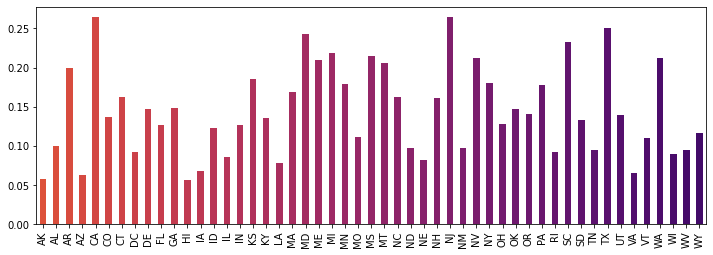

In [45]:
# số lượng khách hàng hủy ở mỗi state (khu vực)
number_churned_by_state = churned['state'].value_counts()
# tổng số lượng khách hàng theo mỗi state (khu vực)
number_by_state = df_train['state'].value_counts()
# tỷ lệ khách hàng hủy theo mỗi state
churned_rate_by_state = number_churned_by_state/number_by_state

from matplotlib import cm
color = cm.inferno_r(np.linspace(.4, .8, len(churned_rate_by_state)))

churned_rate_by_state.plot(kind='bar', stacked=True, color=color,figsize=(12, 4))


Nhìn vào bảng tỷ lệ khách hàng hủy dịch vụ theo state ta thấy ở 2 state là CA và NJ có tỷ lệ hủy dịch vụ là cao nhất

<AxesSubplot:>

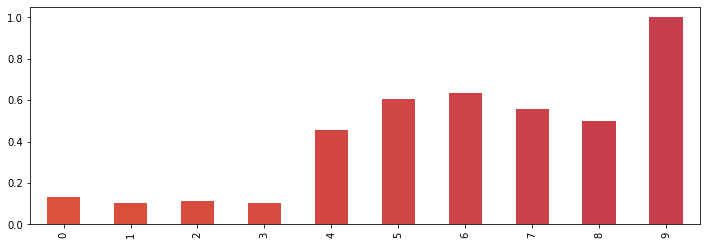

In [46]:
# Tính tỷ lệ khách hàng hủy dịch vụ theo number_customer_service_calls (số lượng các cuộc gọi tới dịch vụ chăm sóc khách hàng)
number_churned_by_NCSC = churned['number_customer_service_calls'].value_counts()
number_by_NCSC = df_train['number_customer_service_calls'].value_counts()
NCSC_rate = number_churned_by_NCSC/number_by_NCSC
NCSC_rate.plot(kind='bar', stacked=True, color=color,figsize=(12, 4))


Biểu đồ trên thấy số lượng cuộc gọi tới dịch vụ chăm sóc khách hàng càng nhiều thì tỷ lệ hủy gói dịch vụ càng cao (tỷ lệ thuận)
Điều này cho thấy, dịch vụ chăm sóc khách hàng là khá tệ và có thể là nguyên nhân dẫn tới việc hủy dịch vụ của khách hàng.

## Task 2

In [47]:
# lựa chọn các feature cho mô hình dựa đoán
def select_feature(input):
    # feature selection
    X = input[["account_length", "international_plan","number_vmail_messages", "total_day_minutes", "total_eve_charge", "total_intl_calls", "number_customer_service_calls"]]
  
    X = X.values
    # Chuẩn hóa trường international_plan với 2 giá trị ['yes','no'] về [1,0]
    international_plan=preprocessing.LabelEncoder()
    international_plan.fit(["no", "yes"])
    X[:,1] = international_plan.transform(X[:,1])
    
    y = input["churn"]
    return [X,y]

In [48]:
SF_train = select_feature(df_train)
SF_test = select_feature(df_test)

X_train = SF_train[0]
y_train = SF_train[1]
X_test = SF_test[0]
y_test = SF_test[1]

X_train[0:5]

array([[128, 0, 25, 265.1, 16.78, 3, 1],
       [107, 0, 26, 161.6, 16.62, 3, 1],
       [137, 0, 0, 243.4, 10.3, 5, 0],
       [84, 1, 0, 299.4, 5.26, 7, 2],
       [75, 1, 0, 166.7, 12.61, 3, 3]], dtype=object)

In [49]:
# Sử dụng mô hình Random Forest để dự đoán
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=30)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30)

In [50]:
# Dự đoán bằng mô hình 
rf_pred = rf_model.predict(X_test)
rf_pred[0:100]

array(['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no'], dtype=object)

In [51]:
# confusion matrics to find precision and recall
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, rf_pred)

array([[1429,   14],
       [  91,  133]], dtype=int64)

In [52]:
def print_score(y_test,pred):
    AS = accuracy_score(y_test, pred)
    print('accuracy_score = {}'.format(AS))
    PS = precision_score(y_test, pred, pos_label='yes')
    print( 'precision_score = {}'.format(PS))
    RS = recall_score(y_test, pred, pos_label='yes')
    print( 'recall_score = {}'.format(RS))
    F1 = f1_score(y_test, pred, pos_label='yes')
    print( 'f1_score = {}'.format(F1))
    return [AS, PS, RS, F1]

In [53]:
# Kết quả thu được với mô hình Random Forest
RF_result = print_score(y_test,rf_pred)

accuracy_score = 0.9370125974805039
precision_score = 0.9047619047619048
recall_score = 0.59375
f1_score = 0.7169811320754718


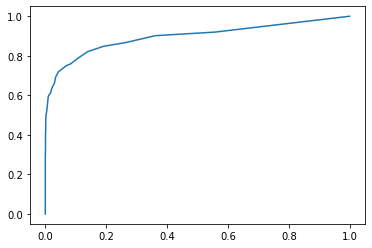

In [54]:
# Vẽ ROC
prob=rf_model.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_test, prob, pos_label='yes')
plt.plot(fpr, tpr)


In [55]:
# Looking at the area under the curve
from sklearn.metrics import roc_auc_score
auc=roc_auc_score(y_test, prob)
RF_result.append(auc)
auc


0.8961148648648649

In [56]:
# Sử dụng mô hình SVM 
from sklearn.svm import SVC
svc_model=SVC(probability=True,degree=1)
svc_model.fit(X_train, y_train)

SVC(degree=1, probability=True)

In [57]:
svc_pred = svc_model.predict(X_test)
svc_pred[0:100]

array(['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no'], dtype=object)

In [58]:
SVC_result = print_score(y_test,svc_pred)

accuracy_score = 0.8794241151769646
precision_score = 0.96
recall_score = 0.10714285714285714
f1_score = 0.19277108433734935


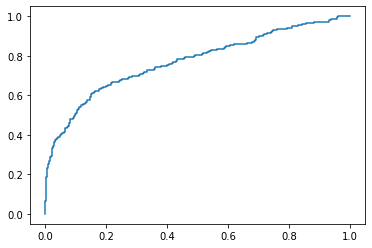

In [59]:
# probability for each prediction
prob_2=svc_model.predict_proba(X_test)[:,1]
# look at ROC curve
fpr, tpr, thresholds=roc_curve(y_test, prob_2, pos_label='yes')
plt.plot(fpr, tpr)


In [60]:
# area under the curve
auc=roc_auc_score(y_test, prob_2)
SVC_result.append(auc)
auc


0.7716748341748342

In [61]:
from sklearn.model_selection import GridSearchCV
# find ideal degree for SVM model
param_grid_2={'degree': np.arange(1,10)}
svc_cv=GridSearchCV(SVC(), param_grid_2)
svc_cv.fit(X_train,y_train)
svc_cv.best_params_

{'degree': 1}

## Task 3

[0.9370125974805039, 0.9047619047619048, 0.59375, 0.7169811320754718, 0.8961148648648649]


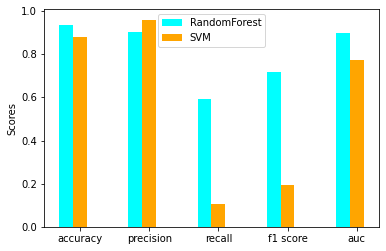

In [63]:
# index = ['accuracy', 'precision', 'recall', 'f1', 'auc']
# plt.bar(index, RF_result)
# create data
x = np.arange(5)

width = 0.2
print(RF_result)
# plot data in grouped manner of bar type
plt.bar(x-0.2, RF_result, width, color='cyan')
plt.bar(x, SVC_result, width, color='orange')
plt.xticks(x, ['accuracy', 'precision', 'recall', 'f1 score', 'auc'])

plt.ylabel("Scores")
plt.legend(["RandomForest", "SVM"])
plt.show()

Nhìn vào biểu đồ so sánh 2 mô hình bên trên ta thấy rõ ràng mô hình Random Forest có hiệu quả hơn so với mô hình SVM